In [ ]:
from functions import *
import numpy as np


# Example
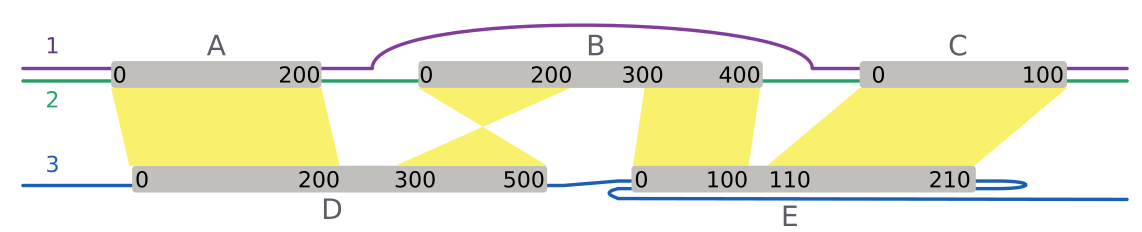

In [ ]:
LA = 200
LB = 400
LC = 100
LD = 500
LE = 210

# nodes
n1_A_1 = Node(id=1, block_id=1, path_id=1, strandedness=True, position=(0,100))
n2_C_1 = Node(id=2, block_id=3, path_id=1, strandedness=True, position=(100,200))
n3_A_2 = Node(id=3, block_id=1, path_id=2, strandedness=True, position=(0,100))
n4_B_2 = Node(id=4, block_id=2, path_id=2, strandedness=True, position=(100,500))
n5_C_2 = Node(id=5, block_id=3, path_id=2, strandedness=True, position=(500,600))
n6_D_3 = Node(id=6, block_id=4, path_id=3, strandedness=True, position=(0,500))
n7_E_3 = Node(id=7, block_id=5, path_id=3, strandedness=True, position=(500, 710))
n8_E_3 = Node(id=8, block_id=5, path_id=3, strandedness=False, position=(710, 920))
nodes = {n.id: n for n in [
    n1_A_1,
    n2_C_1,
    n3_A_2,
    n4_B_2,
    n5_C_2,
    n6_D_3,
    n7_E_3,
    n8_E_3,
]}

# paths
p1 = Path(id=1, nodes=[1, 2], L=200)
p2 = Path(id=2, nodes=[3, 4, 5], L=600)
p3 = Path(id=3, nodes=[6, 7, 8], L=920)
paths = {p.id: p for p in [p1, p2, p3]}

# blocks
np.random.seed(0)
new_seq = lambda L: ''.join(np.random.choice(list("ACGT"), L))
bA = Block(id=1, consensus=new_seq(LA), alignment={1:None, 3:None})
bB = Block(id=2, consensus=new_seq(LB), alignment={4:None})
bC = Block(id=3, consensus=new_seq(LC), alignment={2:None, 5:None})
bD = Block(id=4, consensus=new_seq(LD), alignment={6:None})
bE = Block(id=5, consensus=new_seq(LE), alignment={7:None, 8:None})
blocks = {b.id: b for b in [bA, bB, bC, bD, bE]}
graph = Pangraph(nodes=nodes, paths=paths, blocks=blocks)

# matches
new_aln = lambda qry, reff, s: Alignment(qry=qry, reff=reff, orientation=s)
h1_A = Hit(name=1, length=200, start=0, stop=200)
h1_D = Hit(name=4, length=200, start=0, stop=200)
a1 = new_aln(qry=h1_A, reff=h1_D, s=True)
h2_B = Hit(name=2, length=200, start=0, stop=200)
h2_D = Hit(name=4, length=200, start=300, stop=500)
a2 = new_aln(qry=h2_B, reff=h2_D, s=False)
h3_B = Hit(name=2, length=100, start=300, stop=400)
h3_E = Hit(name=5, length=100, start=0, stop=100)
a3 = new_aln(qry=h3_B, reff=h3_E, s=True)
h4_C = Hit(name=3, length=100, start=0, stop=100)
h4_E = Hit(name=5, length=100, start=110, stop=210)
a4 = new_aln(qry=h4_C, reff=h4_E, s=True)
matches = [a1, a2, a3, a4]



In [ ]:

def split_block(bid, M, graph, thr_len) -> tuple[GraphUpdate, list[Block]]:
    """
    
    """

    T = extract_hits(bid, M)

    # from hits to intervals
    L = graph.blocks[bid].consensus_len()
    I = extract_intervals(T, L, thr_len)
    print(f"refined intervals: {I}")

    # prepare graph update and list of half-merge promises
    u = GraphUpdate(
        b_old_id=bid,
        b_new=[],
        n_new={nid: [] for nid in graph.blocks[bid].alignment.keys()},
    )
    H = []
    # cut block on intervals (generate new block/nodes)
    b = graph.blocks[bid]
    for i in I:
        b_slice, n_dict = block_slice(b, i, graph)
        # u.update(n_dict, paths...) TODO
        u.b_new.append(b_slice)
        for old_nid, new_node in n_dict.items():
            u.n_new[old_nid].append(new_node)

        if i.aligned:
            H.append((b_slice, i.deep, i.orientation))
    
    # flip order in node lists for paths that are inverted
    for old_node_id, nodes in u.n_new.items():
        strand = graph.nodes[old_node_id].strandedness
        if not strand:
            u.n_new[old_node_id] = list(reversed(nodes))

    return u, H



from itertools import groupby

def group_promises(H: list[tuple[Block, bool, bool]]) -> list[MergePromise]:
    """
    Given a list of blocks to merge, it groups them by merge-id and 
    returns a list of merge promises.
    """
    promises = []
    for new_bid, Bs in groupby(H, key=lambda x: x[0].id): # group by new block id
        Bs = list(Bs)
        assert len(Bs) == 2, "Only two blocks can be merged"
        b1, deep1, strand1 = Bs[0]
        b2, deep2, strand2 = Bs[1]
        assert deep1 ^ deep2, "One block must be deep and the other shallow"
        assert strand1 == strand2, "Strandedness information is the same"
        b_deep = b1 if deep1 else b2
        b_shallow = b2 if deep1 else b1
        promises.append(MergePromise(b_deep=b_deep, b_shallow=b_shallow, orientation=strand1))
    return promises



def reweave(mergers: list[Alignment], graph: Pangraph, thr_len: int) -> tuple[list[MergePromise], Pangraph]:

    assign_new_block_ids(mergers) # creates new block ids
    assign_deep_block(mergers, graph) # decides which block is the deep one

    # extract targeted blocks and corresponding mergers
    TB = target_blocks(mergers)

    # for every block, split it according to the mergers
    U, H = [], []
    for bid, M in TB.items(): # can be done in parallel: the graph and block are not modified at this stage
        graph_update, half_promises = split_block(bid, M, graph, thr_len)
        U.append(graph_update)
        H += half_promises

    # group and create merge promises
    merge_promises = group_promises(H)

    for u in U:
        #  inplace graph update
        graph.update(u)


    return graph, merge_promises

reweave(matches, graph, thr_len=50)

def solve_promise(p: MergePromise) -> Block:
    """
    Given a merge promise, it solves it by merging the two blocks.
    Returns the new block.
    """
    for n_id, edits in p.b_shallow.alignment.items():
        seq = apply_edits_to_ref(edits, p.b_shallow)
        if p.orientation:
            seq = reverse_complement(seq)
        append_sequence(p.b_deep, seq, n_id)
    return p.b_deep

In [ ]:
Interval